# Experiment: RPCA vs. Matrix Completion Techniques
# Steam Games Dataset

### Neil Menghani and Jeffrey Tumminia

### Required Packages:

- cvxpy
- matrix_completion
- fancyimpute
- CVXOPT
- pylab
- seaborn
- rpca.py file provided; Source: https://github.com/dganguli/robust-pca

In [12]:
import numpy as np
import pandas as pd
# import matrix_completion as mc
# from fancyimpute import KNN, SoftImpute, BiScaler
from pylab import plt
from rpca import R_pca
import seaborn as sns

### Load and Clean Steam Dataset

In [2]:
steam_df = pd.read_csv("steam-200k.csv", header=None, names=['user_id', 'game', 'behavior', 'hours', '0']).drop('0', axis=1)

In [3]:
top_games_df = steam_df.loc[steam_df['behavior'] == 'play']
top_games_df = top_games_df.groupby('game').agg({'user_id':'count', 'hours':'sum'}).sort_values('user_id', ascending=False)
top_games_df = top_games_df.loc[top_games_df['user_id'] >= 100]
top_games = list(top_games_df.index)
top_users_df = steam_df.loc[(steam_df['behavior'] == 'play') & (steam_df['game'].isin(top_games))]
top_users_df = top_users_df.groupby('user_id').agg({'game':'count'}).sort_values('game', ascending=False)
top_users_df = top_users_df.loc[top_users_df['game'] >= 25]
top_users = list(top_users_df.index)
top_users_df

,game
user_id,
49893565,84
55906572,73
11403772,69
48798067,68
36546868,64
...,...
126269125,25
63615483,25
152419713,25


In [4]:
steam_df = steam_df.loc[(steam_df['game'].isin(top_games)) & (steam_df['user_id'].isin(top_users))]
purchase_df = steam_df.loc[steam_df['behavior'] == 'purchase']
play_df = steam_df.loc[steam_df['behavior'] == 'play']
print(len(purchase_df), len(play_df))

9969 8009


In [5]:
users = list(steam_df['user_id'].unique())
games = list(steam_df['game'].unique())
users.sort()
games.sort()
print("Unique Users: {}, Unique Games: {}".format(len(users), len(games)))

Unique Users: 223, Unique Games: 133


In [6]:
np.random.seed(1600)
THRESHOLD = 0.1
play_df['dataset'] = np.random.rand(len(play_df))
play_df['dataset'] = play_df['dataset'].apply(lambda x : 'test' if x < THRESHOLD else 'train')

<ipython-input-6-dd619aff5a0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_df['dataset'] = np.random.rand(len(play_df))
<ipython-input-6-dd619aff5a0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_df['dataset'] = play_df['dataset'].apply(lambda x : 'test' if x < THRESHOLD else 'train')


### Generate Collaborative Filtering Matrix

In [7]:
A = np.zeros((len(users), len(games))) # hours played of games by users
B = np.zeros((len(users), len(games))) # binary matrix specifying known vs. unknown
test_coords = {} # matrix coordinates : hours_played for test data
for i in range(len(users)):
    user = users[i]
    # print(i)
    purchased = purchase_df.loc[purchase_df['user_id'] == user]['game'].unique()
    user_play_df = play_df.loc[play_df['user_id'] == user]
    played = user_play_df['game'].unique()
    hours_played = pd.Series(user_play_df.hours.values, index=user_play_df.game).to_dict()
    dataset = pd.Series(user_play_df.dataset.values, index=user_play_df.game).to_dict()
    for j in range(len(games)):
        game = games[j]
        if game in played:
            if dataset[game] == 'train':
                A[i, j] = hours_played[game]
                B[i, j] = 1
            else:
                test_coords[(i, j)] = hours_played[game]

In [8]:
np.save('steam.npy', A)
np.save('missing.npy', B)

In [9]:
# Center Matrix
A_mean = np.tile(np.mean(A, axis=1), (A.shape[1], 1)).T
A_centered = A - A_mean

In [10]:
rpca = R_pca(A_centered)
L, S = rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 39.681222091932774
iteration: 100, error: 1.6165670541887385
iteration: 200, error: 1.193692331238148
iteration: 300, error: 0.9521524214616774
iteration: 400, error: 0.5907982393912963
iteration: 500, error: 0.4115142312091405
iteration: 600, error: 0.32720843631513713
iteration: 700, error: 0.1433057540668483
iteration: 800, error: 0.14101398575895543
iteration: 900, error: 0.09207050184374352
iteration: 1000, error: 0.07626738357820781
iteration: 1100, error: 0.06375373196912174
iteration: 1200, error: 0.0529068265248956
iteration: 1300, error: 0.05407201510902689
iteration: 1400, error: 0.05163814266092416
iteration: 1500, error: 0.05982186426547346
iteration: 1600, error: 0.05423951826471337
iteration: 1700, error: 0.06109239876227055
iteration: 1800, error: 0.06580548196361566
iteration: 1900, error: 0.05131102861390799
iteration: 2000, error: 0.04839168771046229
iteration: 2100, error: 0.053512880451486534
iteration: 2200, error: 0.049306316657851866
iterati

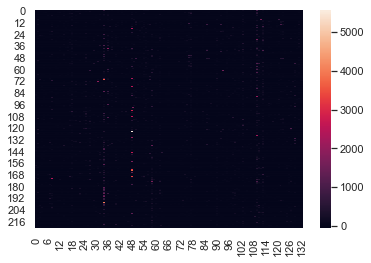

In [20]:
sns.set_theme()
ax = sns.heatmap(A_centered)

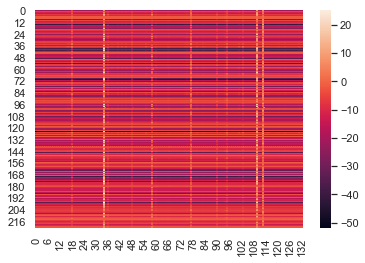

In [15]:
ax = sns.heatmap(L)


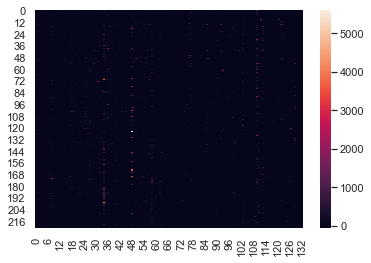

In [16]:
ax = sns.heatmap(S)

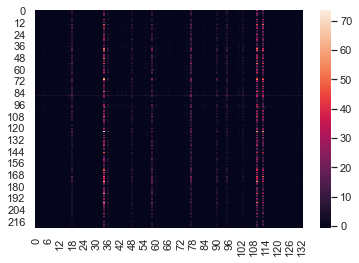

In [24]:
ax = sns.heatmap(L + A_mean)

In [41]:
# Evaluate Test RMSE:
total_error = 0
coords = test_coords.keys()
for coord in coords:
    i, j = coord[0], coord[1]
    hours_pred = L[i, j] + A_mean[i, j]
    hours_true = test_coords[coord]
    total_error += (hours_pred - hours_true)**2
    print(hours_pred, hours_true)
RMSE = np.sqrt(total_error / len(coords))
RMSE

1.7400508143050537 8.3
0.2405858051963783 9.7
1.7331859680780326e-07 6.9
1.1550127782953545 40.0
9.349408743197785e-06 0.2
5.1832947818297725e-06 4.1
0.9519466434288244 39.0
0.0004092473707970612 3.4
0.5420885193685301 2.3
0.2661918587868435 1.7
3.612025713623538 0.9
3.8717641391653963 0.3
0.6451144656946433 9.8
8.552382324999996e-06 152.0
0.45671659910049733 13.2
3.208365860984941e-06 9.1
4.6111040061802555e-06 14.0
0.004631686203024898 16.3
0.4711460931390725 1.1
1.3643787878590814 4.6
0.00489526523648709 1.2
-2.2680845845446385e-05 6.2
0.010996841836571347 2.0
0.1360733844900932 0.3
0.001906569085039278 15.0
1.8019731262697292e-07 175.0
-0.0010259369476128821 37.0
-1.3745172855905707e-05 1.7
-1.7103953042552078e-05 0.2
1.5223131974329007e-05 13.1
0.40960177330707737 54.0
17.82870330708353 13.7
0.24051349801518995 4.2
0.0742216476215809 0.8
0.2198312782406351 14.6
1.2252497553701844 5.1
0.023426604766782155 2.1
0.08464494963353175 0.5
0.5990166674235899 4.4
0.035769229659819324 15.3


316.98786412504285

In [42]:
# Evaluate Test RMSE:
total_error = 0
coords = test_coords.keys()
for coord in coords:
    i, j = coord[0], coord[1]
    hours_pred = A[i, j]
    hours_true = test_coords[coord]
    total_error += (hours_pred - hours_true)**2
    print(hours_pred, hours_true)
RMSE = np.sqrt(total_error / len(coords))
RMSE

0.0 8.3
0.0 9.7
0.0 6.9
0.0 40.0
0.0 0.2
0.0 4.1
0.0 39.0
0.0 3.4
0.0 2.3
0.0 1.7
0.0 0.9
0.0 0.3
0.0 9.8
0.0 152.0
0.0 13.2
0.0 9.1
0.0 14.0
0.0 16.3
0.0 1.1
0.0 4.6
0.0 1.2
0.0 6.2
0.0 2.0
0.0 0.3
0.0 15.0
0.0 175.0
0.0 37.0
0.0 1.7
0.0 0.2
0.0 13.1
0.0 54.0
0.0 13.7
0.0 4.2
0.0 0.8
0.0 14.6
0.0 5.1
0.0 2.1
0.0 0.5
0.0 4.4
0.0 15.3
0.0 1.1
0.0 14.8
0.0 1.8
0.0 9.7
0.0 29.0
0.0 6.9
0.0 109.0
0.0 0.7
0.0 1.5
0.0 0.9
0.0 169.0
0.0 11.3
0.0 3.6
0.0 124.0
0.0 0.3
0.0 11.0
0.0 19.9
0.0 7.0
0.0 84.0
0.0 1.0
0.0 0.8
0.0 5.0
0.0 0.9
0.0 1.5
0.0 3.8
0.0 4.2
0.0 13.3
0.0 744.0
0.0 1.4
0.0 1.3
0.0 0.4
0.0 3.2
0.0 3.3
0.0 0.5
0.0 0.1
0.0 6.3
0.0 61.0
0.0 11.9
0.0 7.0
0.0 19.1
0.0 37.0
0.0 14.0
0.0 11.4
0.0 2.7
0.0 171.0
0.0 2.6
0.0 51.0
0.0 629.0
0.0 17.4
0.0 5.1
0.0 2.6
0.0 101.0
0.0 42.0
0.0 1.6
0.0 8.5
0.0 43.0
0.0 389.0
0.0 5.3
0.0 9.1
0.0 0.3
0.0 35.0
0.0 20.0
0.0 30.0
0.0 3.2
0.0 5.2
0.0 11.4
0.0 12.8
0.0 436.0
0.0 0.3
0.0 37.0
0.0 45.0
0.0 19.1
0.0 2.2
0.0 75.0
0.0 4.1
0.0 15.4
0.0 32.0
0.

318.03365639543426

### matrix_completion

- NuclearNorm
- Probabilistic Matrix Factorization with ALS

In [33]:
#% of values present
sum(sum(B))/(B.shape[0]*B.shape[1])

0.24286051451498702

In [35]:
A_centered

array([[-20.79172932,  20.20827068, -20.79172932, ..., -20.39172932,
          4.20827068, -20.79172932],
       [ -5.1556391 ,  -5.1556391 ,  -5.1556391 , ...,  -5.1556391 ,
         -5.1556391 ,  -5.1556391 ],
       [-11.29097744, -11.29097744, -11.29097744, ..., -11.29097744,
         29.70902256, -11.29097744],
       ...,
       [ -1.7481203 ,  -1.7481203 ,  -1.7481203 , ...,  -1.7481203 ,
         -1.7481203 ,  -1.7481203 ],
       [ -9.33909774,  -5.73909774,  -9.33909774, ...,  -9.33909774,
         -9.33909774,  -9.33909774],
       [ -2.19398496,  -2.19398496,  17.80601504, ...,  -2.19398496,
         -2.19398496,  -2.19398496]])

In [38]:
import matrix_completion as mc

ModuleNotFoundError: No module named 'cvxpy'

In [37]:
m = 1/np.sqrt(max(A_centered.shape))
R_hat = mc.nuclear_norm_solve(A_centered, B, mu=m)
out = R_hat+mean
print(out.shape)
out

NameError: name 'mc' is not defined

In [ ]:
R_hat

In [ ]:
R_pmf = mc.pmf_solve(stm_norm, mask, k=50, mu=1e-2, max_iterations=500)

In [ ]:
R_pmf+mean

### fancyimpute Knn

In [ ]:
stm[mask==0]=np.nan
stm_knn = KNN(k=3).fit_transform(stm)

In [ ]:
stm

In [ ]:
stm_knn

In [ ]:
# Instead of solving the nuclear norm objective directly, instead
# induce sparsity using singular value thresholding
stm_normalized = BiScaler().fit_transform(stm)
stm_softimpute = SoftImpute().fit_transform(stm_normalized)

In [ ]:
stm_softimpute